# 利用CNN預測人物圖片表情
training dataset：兩萬八千張左右48x48 pixel的圖片

總共有七種可能的表情（0：生氣, 1：厭惡, 2：恐懼, 3：高興, 4：難過, 5：驚訝, 6：中立(難以區分為前六種的表情))

### [Kaggle競賽](https://www.kaggle.com/c/ml-2017fall-hw3/overview)

# 原始資料

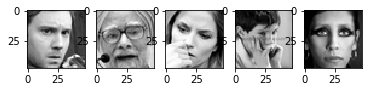

In [8]:
import cv2
import numpy as np
import csv
import matplotlib.pyplot as plt

traincsv = csv.DictReader(open('train.csv','r'),quoting=csv.QUOTE_NONE)
raw_data = []
for row in traincsv:
    raw_data.append(row)
for i in range(5):
    pic = raw_data[i]['feature'].split(' ')
    pic = np.array(pic,np.int)
    pic = np.reshape(pic,(48,48))
    outputname = 'pic'+str(i)+'.png'
    plt.subplot(1,5,i+1)
    plt.imshow(pic, cmap='gray')
    

# Training
```使用 categorical_crossentropy 來計算損失函數，優化器則使用 adadelta。
在 training_model 的部分，利用 np.rot90 來將圖片旋轉 90 度增加 data 數量。 取 50000 個 data train，
最後面 7418 個 data 做 validation。 Epoch=80，batch=128，但會在中間儲存 validation accuracy 最高的 data。 ```

(28709, 2304)


/home/cnrg-ntu/anaconda3/envs/jiayu/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(48, 48, 1...)`
/home/cnrg-ntu/anaconda3/envs/jiayu/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/home/cnrg-ntu/anaconda3/envs/jiayu/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
/home/cnrg-ntu/anaconda3/envs/jiayu/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
/home/cnrg-ntu/anaconda3/envs/jiayu/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
/home/cnrg-ntu/anaconda3/envs/jiayu/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: The `nb_epoch` 

Train on 50000 samples, validate on 7418 samples
Epoch 1/80
50000/50000 [==============================] - 14s 289us/step - loss: 1.8750 - acc: 0.2279 - val_loss: 1.7964 - val_acc: 0.2565
Epoch 2/80
50000/50000 [==============================] - 12s 246us/step - loss: 1.7483 - acc: 0.2894 - val_loss: 1.7578 - val_acc: 0.2811
Epoch 3/80
50000/50000 [==============================] - 14s 272us/step - loss: 1.6274 - acc: 0.3518 - val_loss: 1.6677 - val_acc: 0.3334
Epoch 4/80
50000/50000 [==============================] - 13s 254us/step - loss: 1.5401 - acc: 0.3940 - val_loss: 1.4538 - val_acc: 0.4211
Epoch 5/80
50000/50000 [==============================] - 13s 260us/step - loss: 1.4805 - acc: 0.4198 - val_loss: 1.7184 - val_acc: 0.2916
Epoch 6/80
50000/50000 [==============================] - 12s 250us/step - loss: 1.4353 - acc: 0.4458 - val_loss: 1.5270 - val_acc: 0.4161
Epoch 7/80
50000/50000 [==============================] - 13s 252us/step - loss: 1.4003 - acc: 0.4622 - val_loss: 1.6

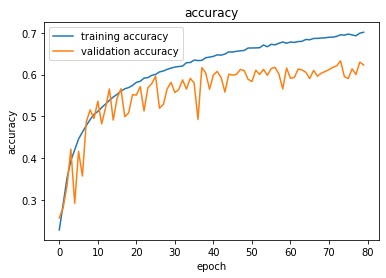

In [9]:
import csv
import sys
import numpy as np
np.random.seed(1019)
from keras.models import Sequential,load_model 
from keras.layers import Dense, Dropout, Activation, Flatten 
from keras.layers import Convolution2D, MaxPooling2D ,ZeroPadding2D,AveragePooling2D
from keras.layers.normalization import BatchNormalization 
from keras.utils import np_utils 
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras.backend.tensorflow_backend as ktf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


def get_session():
    gpu_options = tf.GPUOptions(allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

def main():
    
    epoch = 80

    #training data
    training_data = 'train.csv'
    raw_data = []
    traincsv = csv.DictReader(open(training_data,'r'),quoting=csv.QUOTE_NONE)

    for row in traincsv:
        raw_data.append(row)

    raw_label = []
    data = []
    for item in raw_data:
        raw_label.append(item['label'])
        data.append(item['feature'].split(' '))

    raw_label = np.array(raw_label,dtype=np.int)
    label = np.zeros((raw_label.shape[0],7))
    
    data = np.array(data,dtype=np.int)
    for i in range(raw_label.shape[0]):
        label[i][raw_label[i]]=1
    print(data.shape)
    
    model = training(data,label,epoch)
    model.save('model'+str(epoch)+'.h5')
    
def training(data,label,epoch):        
    batch_size = 128
    nb_classes = 7

    #number of convolutional filter
    nb_filters = 64
    #size of pooling area for max pooling
    pool_size = (2,2)
    #convolution kernal size
    kernal_size = (3,3)

    data = data.reshape(data.shape[0], 48, 48, 1)
    rotate = np.rot90(data,axes=(1,2))
    data = np.concatenate((rotate ,data),axis=0)
    data = data /255
    label = np.concatenate((label,label),axis=0) 
        
    model = Sequential()
    
    #cnn1
    model.add(Convolution2D(64,5,5,input_shape = (48,48,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(5,5),strides=(2,2)))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Dropout(0.3))
    #cnn2
    model.add(Convolution2D(64, kernal_size[0], kernal_size[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Dropout(0.3))
    #cnn3
    model.add(Convolution2D(128, kernal_size[0], kernal_size[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Dropout(0.3))
    #cnn4
    model.add(Convolution2D(128, kernal_size[0], kernal_size[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Dropout(0.3))
    #cnn5
    model.add(Convolution2D(128, kernal_size[0], kernal_size[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Dropout(0.3))
    #dnn1
    model.add(Flatten()) 
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) 
    #dnn2
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) 
    #dnn3
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) 
    #output
    model.add(Dense(nb_classes)) 
    model.add(Activation('softmax'))
    #compile
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    filepath="weights-{epoch:02d}-{val_acc:.4f}.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)
    callbacks_list = [checkpoint]

    #training
    history = model.fit(data[:50000], label[:50000], batch_size=batch_size, nb_epoch=epoch,verbose=1,validation_data=(data[50000:],label[50000:]))
    print(history.history.keys())
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training accuracy', 'validation accuracy'])
    plt.show()
    return model


if __name__=='__main__':
    main()


# Testing

In [6]:
import csv
import sys
import numpy as np
np.random.seed(1019)
from keras.models import Sequential,load_model 
from keras.utils import np_utils 
from keras import optimizers
import tensorflow as tf
import keras.backend.tensorflow_backend as ktf


def get_session():
    gpu_options = tf.GPUOptions(allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

def main():
    
    #testing data
    testing_data = sys.argv[1]
    raw_test = []
    testcsv = csv.DictReader(open("./train.csv",'r'),quoting=csv.QUOTE_NONE)

    for row in testcsv:
        raw_test.append(row)

    test = []
    for item in raw_test:
        test.append(item['feature'].split(' '))
    test = np.array(test,dtype=np.int)
    
    model = load_model("hw3.h5")
    pred = testing(test,model)
    output(pred,"pred.csv")

def testing(test,model):
    test = test.reshape(test.shape[0], 48, 48, 1)
    test = test/255
    pred = model.predict_classes(test)
    #print(pred)
    return pred

def output(pred,output):
    with open(output,'w') as f:
        f.write('id,label\n')
        for i in range(pred.size):
            f.write(str(i)+','+str(int(pred[i]))+'\n')

if __name__=='__main__':
    main()

# confusion_matrix

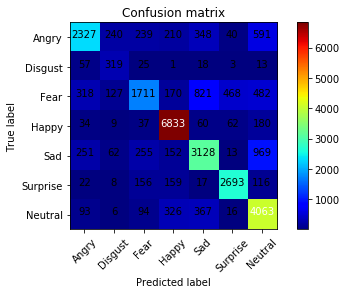

In [7]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import csv


def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.jet):
    """
    This function prints and plots the confusion matrix.
    """
    cm1 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    cm = cm.astype(int)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d}'.format(cm[i, j]), horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

    

def read_dataset(data_path):
    train_pixels = load_pickle(data_path)
    for i in range(len(train_pixels)):
        train_pixels[i] = np.fromstring(train_pixels[i], dtype=float, sep=' ').reshape((48, 48, 1))
    return np.asarray(train_pixels)

def get_labels(data_path):
    train_labels = load_pickle(data_path)
    train = []
    for i in range(len(train_labels)):
        train.append(int(train_labels[i]))
    return np.asarray(train)

def main():
    #model_path = 'hw3.h5'
    #emotion_classifier = load_model(model_path)
    np.set_printoptions(precision=2)
    training_data = 'train.csv'
    answer_data = 'pred.csv'
    raw_data = []
    traincsv = csv.DictReader(open(training_data,'r'),quoting=csv.QUOTE_NONE)
    for row in traincsv:
        raw_data.append(row)
    label = []
    predictions = []
    for item in raw_data:
        label.append(item['label'])
    answercsv = csv.DictReader(open(answer_data,'r'),quoting=csv.QUOTE_NONE)
    raw_data = []
    for row in answercsv:
        raw_data.append(row)
    for item in raw_data:
        predictions.append(item['label'])

    label = np.array(label,dtype=np.int)
    predictions = np.array(predictions,dtype=np.int)
    

    #predictions = emotion_classifier.predict_classes(data)
    #print (predictions)
    #print (label)
    conf_mat = confusion_matrix(label,predictions)
    plt.figure()
    plot_confusion_matrix(conf_mat, classes=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"])
    plt.show()

if __name__=='__main__':
    main()


```由圖可發現，由於 happy 的 model 最多，因此判斷起來的準確率也最高;而比例上較多判錯的則是 fear 跟 sad 之間，或者是把 label 錯判成 neutral，由於 neutral 很難定義，因此滿容易誤判。```